# Ensembling

The aim of this notebook is to test whether ensembling the neural networks will give better result than simply using one or another. For this purpose 3 encoder-decoder architectures were chosen keeping in mind that the best results are usually produced by diverse range of architectures:

- [Inception](https://arxiv.org/abs/1409.4842) & [Unet++](https://arxiv.org/pdf/1807.10165.pdf)
- [SegFormer](https://arxiv.org/pdf/2105.15203.pdf) & [Unet](https://arxiv.org/abs/1505.04597)
- [EfficientNet](https://arxiv.org/abs/1905.11946) & [Unet++](https://arxiv.org/pdf/1807.10165.pdf)

## Google Colab

The following two cells will be necessary in Google Colab. To avoid problems with imports, they are included in the notebook.

In [1]:
import sys

import matplotlib.pyplot as plt

from scripts.inference import Ensembler
from scripts.plotting import plot_cv_per_epoch

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive

    drive.mount('/content/drive')

In [2]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str:
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive=True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('ensembling.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [3]:
import os
import cv2
import torch

import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold
from scripts.evaluation import EvaluationMonitor
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import setup_seed, valid_epoch, train_epoch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

In [4]:
# hacky way for avoid problems with SSL when downloading some of the models
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# setup seed for every possible way (numpy, Python, random, torch)
SEED = 16
setup_seed(SEED)

## Data

Specify the data directory and transformations. Notice that the data must first be downloaded using bash script (see README).

In [6]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [7]:
# image paths so that all the images are used for train dataset
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

In [8]:
# define transformations
train_tf = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5)
])

valid_tf = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

## Hyperparameters

Specify hyperparameters for the experiments. As the aim of this notebook is to see if ensembling shows better results than using models alone, we can confine with 50 epochs. We will simply compare ensembling with separate models epoch-by-epoch. 

In [9]:
ENCODER_WEIGHTS = 'imagenet'
BATCH_SIZE = 4
K_FOLD = 3
N_CPU = os.cpu_count()
N_EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Encode-Decoder Combinations

As mentioned before, we picked diverse range of models that include one with quite limited number of parameters (EfficientNet), one with the best performance in the earlier benchmarks (Inception) and one with Transformer architecture (SegFold).

In [10]:
encoder_decoder = [
    ('inceptionv4', 'UnetPlusPlus'),
    ('mit_b2', 'Unet'),
    ('efficientnet-b4', 'UnetPlusPlus')
]

## Cross-Validation

Cross-validation will this time be a little different since we want to use the same images with the same transformations for all models. Thus, the encapsulation follows the logic fold -> epoch -> model. 

In [9]:
# specify the object to save the training and validation results
eval_monitor = EvaluationMonitor(os.path.join(ROOT_PATH, 'data', 'results', 'ensembling'))

In [ ]:
k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

# Get training and validation indices
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

    # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
    train_loader = DataLoader(
        train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), batch_size=BATCH_SIZE
    )

    valid_loader = DataLoader(
        train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), batch_size=BATCH_SIZE
    )
    
    # specify models, scheduler, criterion and optimizer
    models = [
        smp.create_model(
            decoder, encoder_name=encoder, encoder_weights=ENCODER_WEIGHTS
        ).to(DEVICE) for encoder, decoder in encoder_decoder
    ]

    optimizers = [torch.optim.Adam(model_.parameters(), lr=0.0005) for model_ in models]
    t_max = (len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size
    schedulers = [CosineAnnealingLR(optimizer_, T_max=t_max, ) for optimizer_ in optimizers]
    criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    zipped_values = [encoder_decoder, models, optimizers, schedulers]

    for i in range(N_EPOCHS):

        ensembler = Ensembler()

        # since we want to have the same transformations for every model
        train_data = [(image, mask) for image, mask in train_loader]
        valid_data = [(image, mask) for image, mask in valid_loader]

        for (enc, dec), model_, opt_, sched_ in zip(*zipped_values):
            ensembler.set_model(enc, dec)

            _, train_f1 = train_epoch(
                model_, train_data, criterion_, opt_, sched_, i + 1, ensembler=ensembler
            )
            _, valid_f1 = valid_epoch(
                model_, valid_data, criterion_, i + 1, ensembler=ensembler
            )

            eval_monitor.update_metrics_by_fold(
                setup='+'.join([enc, dec]),
                fold=fold,
                training_f1=train_f1,
                validation_f1=valid_f1
            )

        # log the results of meta learner
        eval_monitor.update_metrics_by_fold(
            setup='ensembling',
            fold=fold,
            training_f1=ensembler.get_f1('training'),
            validation_f1=ensembler.get_f1('validation')
        )

    eval_monitor.update_jsons()

## Ensembling

CV was run on colab, the results saved to JSON, and now we can compare the results.

<Figure size 640x480 with 0 Axes>

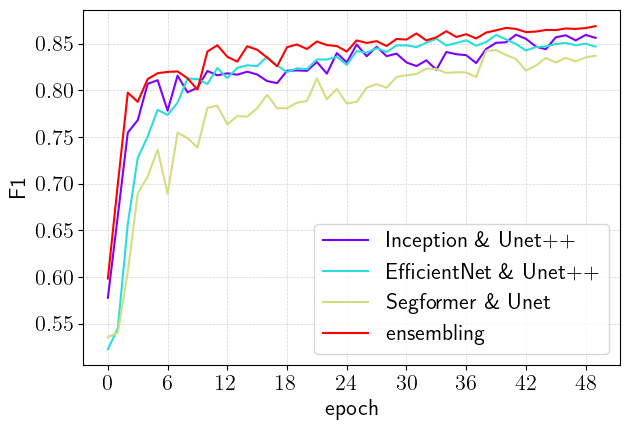

In [16]:
cv_val = eval_monitor.data['validation_f1']

cv_data = {
    r'Inception \& Unet++': np.array(cv_val[('inceptionv4', 'UnetPlusPlus')]),
    r'EfficientNet \& Unet++': np.array(cv_val[('efficientnet-b4', 'UnetPlusPlus')]),
    r'Segformer \& Unet': np.array(cv_val[('mit_b2', 'Unet')]),
    r'ensembling': np.array(cv_val[('ensembling',)])
}

plot_cv_per_epoch(
    y_label='F1',
    x_label='epoch',
    title='',
    is_std=False,
    **cv_data
)